In [23]:
import pandas as pd
import re
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import * 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:

from google.colab import files
uploaded = files.upload()

Saving Test.csv to Test.csv
Saving Train.csv to Train.csv


In [9]:
import io

Test_Dataset = pd.read_csv(io.BytesIO(uploaded['Test.csv']))
Train_Dataset = pd.read_csv(io.BytesIO(uploaded['Train.csv']),encoding="ISO-8859-1")



In [10]:
Train_Dataset.shape, Test_Dataset.shape

((41157, 6), (3798, 6))

In [11]:
Train_Dataset.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [12]:
Test_Dataset.isnull().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

In [13]:
Train_Dataset = Train_Dataset.drop(columns='Location')
Test_Dataset = Test_Dataset.drop(columns='Location')

In [14]:
#Combining the Train and test set for data pre-processing
All_Tweets = Train_Dataset.append(Test_Dataset, ignore_index=True) 
All_Tweets.shape

(44955, 5)

In [15]:
#Removing unwanted symbols 
ct = re.compile("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|([^0-9A-Za-z t])|(http\S+)")
tweets = []
for tweet in All_Tweets["OriginalTweet"]:
    tweets.append(ct.sub(" ", tweet))
All_Tweets = pd.concat([All_Tweets, pd.DataFrame(tweets, columns=["CleanedTweet"])], axis=1, sort=False)
All_Tweets.head()

,UserName,ScreenName,TweetAt,OriginalTweet,Sentiment,CleanedTweet
0,3799,48751,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,Gahan and and
1,3800,48752,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...
2,3801,48753,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia Woolworths to give elde...
3,3802,48754,16-03-2020,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...
4,3803,48755,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,Me ready to go at supermarket during the ou...


In [16]:
# Removing short words
All_Tweets["CleanedTweet"] = All_Tweets["CleanedTweet"].apply(lambda x: " ".join([w for w in x.split() if len(w)>2]))

In [17]:
# Tokenization
tokenized_tweet = All_Tweets["CleanedTweet"].apply(lambda x: x.split()) 
tokenized_tweet.tail()

44950    [Meanwhile, Supermarket, Israel, People, dance...
44951    [Did, you, panic, buy, lot, non, perishable, i...
44952    [Asst, Prof, Economics, was, talking, about, h...
44953    [Gov, need, somethings, instead, biar, rakyat,...
44954    [and, members, are, committed, the, safety, ou...
Name: CleanedTweet, dtype: object

In [18]:
# Stemming
from nltk.stem.porter import * 
stemmer = PorterStemmer() 
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 

In [19]:
tokenized_tweet.tail()

44950    [meanwhil, supermarket, israel, peopl, danc, a...
44951    [did, you, panic, buy, lot, non, perish, item,...
44952    [asst, prof, econom, wa, talk, about, her, rec...
44953    [gov, need, someth, instead, biar, rakyat, ass...
44954    [and, member, are, commit, the, safeti, our, e...
Name: CleanedTweet, dtype: object

In [20]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])    
All_Tweets["CleanedTweet"] = tokenized_tweet

In [21]:
All_Tweets["CleanedTweet"].head()

0                                        gahan and and
1    advic talk your neighbour famili exchang phone...
2    coronaviru australia woolworth give elderli di...
3    food stock not the onli one which empti pleas ...
4    readi supermarket dure the outbreak not becaus...
Name: CleanedTweet, dtype: object

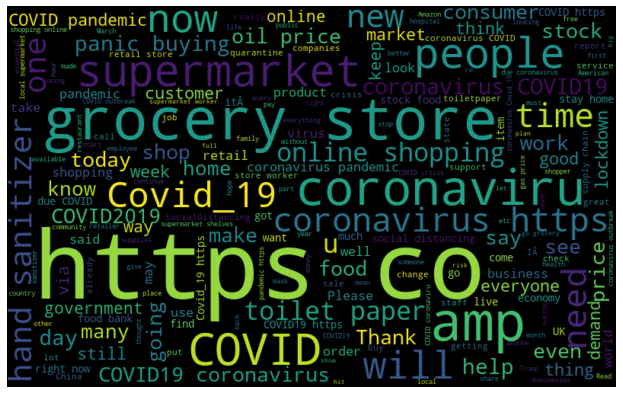

In [50]:
# WordCloud

all_words = ' '.join([text for text in All_Tweets['OriginalTweet']]) 
from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500).generate(all_words) 
plt.figure(figsize=(20, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

In [25]:
#Mapping Sentiments to numerical values
All_Tweets['label'] = All_Tweets['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [26]:
print(All_Tweets['Sentiment'].value_counts())
print(All_Tweets['label'].value_counts())

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64
2    19592
0    17031
1     8332
Name: label, dtype: int64


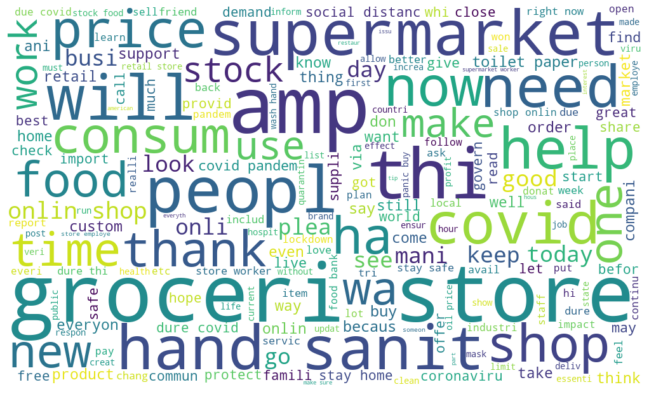

dict_keys(['groceri store', 'amp', 'thi', 'peopl', 'supermarket', 'will', 'hand sanit', 'covid', 'need', 'help', 'now', 'price', 'shop', 'ha', 'consum', 'thank', 'food', 'time', 'wa', 'new', 'one', 'make', 'use', 'work', 'stock', 'onlin shop', 'good', 'plea', 'day', 'keep', 'look', 'today', 'busi', 'see', 'onli', 'go', 'mani', 'toilet paper', 'buy', 'say', 'becaus', 'home', 'support', 'onlin', 'market', 'custom', 'via', 'ani', 'take', 'think', 'even', 'well', 'product', 'still', 'don', 'everyon', 'compani', 'know', 'come', 'thing', 'order', 'want', 'way', 'retail', 'covid pandem', 'suppli', 'find', 'give', 'live', 'may', 'coronaviru', 'free', 'stay home', 'great', 'protect', 'call', 'provid', 'govern', 'whi', 'social distanc', 'hope', 'commun', 'start', 'safe', 'dure covid', 'demand', 'let', 'import', 'share', 'famili', 'check', 'offer', 'best', 'world', 'much', 'read', 'close', 'got', 'befor', 'stay safe', 'ask', 'due', 'report', 'dure thi', 'store worker', 'better', 'chang', 'local',

In [73]:
# Positive tweets

positivewords = ' '.join([text for text in All_Tweets['CleanedTweet'][All_Tweets['label'] == 2]]) 
wordcloud = WordCloud(width=1000, height=600,background_color = 'white').generate(positivewords) 
plt.figure(figsize=(20, 7))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()
print(wordcloud.words_.keys())

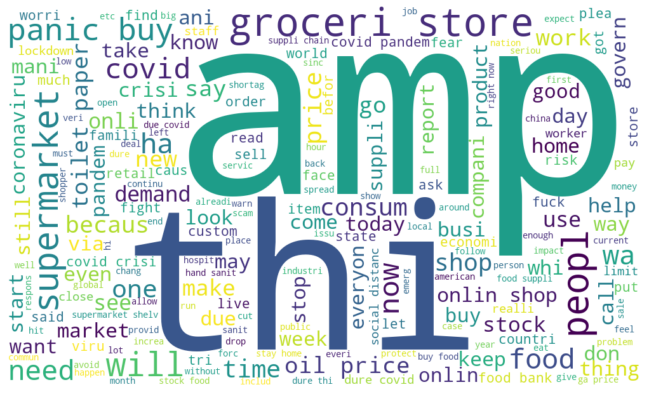

dict_keys(['amp', 'thi', 'groceri store', 'peopl', 'supermarket', 'will', 'panic buy', 'covid', 'now', 'ha', 'food', 'need', 'wa', 'one', 'time', 'consum', 'price', 'shop', 'becaus', 'work', 'say', 'new', 'oil price', 'toilet paper', 'go', 'make', 'use', 'onli', 'see', 'demand', 'stock', 'day', 'even', 'mani', 'market', 'onlin shop', 'stop', 'take', 'whi', 'still', 'today', 'think', 'don', 'busi', 'via', 'look', 'due', 'keep', 'help', 'home', 'crisi', 'ani', 'govern', 'know', 'product', 'report', 'everyon', 'compani', 'come', 'call', 'way', 'thing', 'start', 'may', 'good', 'week', 'want', 'coronaviru', 'suppli', 'onlin', 'pandem', 'buy', 'covid pandem', 'world', 'retail', 'custom', 'tri', 'fear', 'countri', 'order', 'sell', 'said', 'got', 'plea', 'viru', 'much', 'fuck', 'food bank', 'live', 'find', 'item', 'covid crisi', 'worri', 'fight', 'famili', 'economi', 'let', 'ask', 'befor', 'caus', 'read', 'face', 'put', 'store', 'state', 'risk', 'dure covid', 'realli', 'worker', 'close', 'lock

In [71]:
# negative tweets

negativewords = ' '.join([text for text in All_Tweets['CleanedTweet'][All_Tweets['label'] == 0]]) 
wordcloud = WordCloud(width=1000, height=600, background_color = 'white').generate(negativewords) 
plt.figure(figsize=(20, 7))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()
print(wordcloud.words_.keys())

In [28]:
from sklearn.feature_extraction.text import *

stop_words = set(stopwords.words('english'))

#Vectorization
vectorizer = CountVectorizer(max_df=0.90, min_df=3, max_features=3000, stop_words = stop_words) 
vectorizer.fit(All_Tweets['CleanedTweet']) 
DTM = vectorizer.transform(All_Tweets['CleanedTweet']) 
DTM.shape

(44955, 3000)

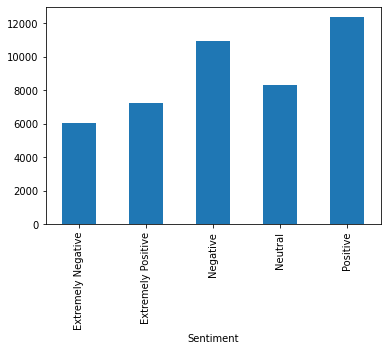

In [44]:
All_Tweets.groupby("Sentiment").label.count().plot.bar(ylim=0)

In [ ]:
output = pd.DataFrame(DTM.toarray(),columns=vectorizer.get_feature_names())
output.T.sort_values(by=0, ascending=False).tail(10)

In [30]:
Test_Dataset['label'] = Test_Dataset['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [31]:
Train_Dataset['label'] = Train_Dataset['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [ ]:
All_Tweets.head()

In [35]:

# Extracting train and test features 
Train_set = DTM[:41157,:]

# splitting data into training and validation set 
X_train, X_test, y_train, y_test = train_test_split(Train_set, Train_Dataset['label'], test_size=0.25)



In [37]:
# XGB Classifier on training data
from xgboost import XGBClassifier

xgb_model = XGBClassifier(max_depth=12, n_estimators=1000).fit(X_train, y_train) 
prediction = xgb_model.predict(X_test) 
print("Accuracy of prediction " + str(accuracy_score(y_test, prediction)*100))

Accuracy of prediction 83.09037900874635


In [38]:
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': prediction})
pred_df.head(100)

,Actual,Predicted
14759,1,2
28877,2,2
9281,0,0
39031,2,2
2858,0,0
...,...,...
5894,2,0
7554,0,0
27594,0,1
21972,1,1
